In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/french-twitter-sentiment-analysis/french_tweets.csv


In [30]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

# Style des graphiques
sns.set(style='whitegrid')

In [31]:
!pip install transformers torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
# Chargement du dataset
data = pd.read_csv('/kaggle/input/french-twitter-sentiment-analysis/french_tweets.csv')
print(f"Taille du dataset : {data.shape}")

# Aperçu des données
data.head()

Taille du dataset : (1526724, 2)


,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."


In [33]:
print("\nInfo :")
print(data.info())
print("\nDistribution originale des labels :")
print(data['label'].value_counts())


Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526724 entries, 0 to 1526723
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1526724 non-null  int64 
 1   text    1526724 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.3+ MB
None

Distribution originale des labels :
label
0    771604
1    755120
Name: count, dtype: int64


In [34]:
TARGET_PER_CLASS = 600000

def safe_sample_per_class(df, label_col='label', n=TARGET_PER_CLASS, random_state=SEED):
    parts = []
    for lbl, group in df.groupby(label_col):
        sample_n = min(len(group), n)
        parts.append(group.sample(n=sample_n, random_state=random_state))
    return pd.concat(parts).reset_index(drop=True)

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#', ' ', text)
    text = re.sub(r'[^a-z0-9àâäéèêëïîôöùûüçœæ\-\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Nettoyage
data['text_clean'] = data['text'].astype(str).map(clean_text)

# Échantillonnage équilibré
data_balanced = safe_sample_per_class(data, label_col='label', n=60000)
print("Distribution équilibrée :")
print(data_balanced['label'].value_counts())

data_balanced[['text', 'text_clean', 'label']].head()

Distribution équilibrée :
label
0    60000
1    60000
Name: count, dtype: int64


,text,text_clean,label
0,"Non, je ne la regarde pas, idk elle.",non je ne la regarde pas idk elle,0
1,"- Très, très vrai.",- très très vrai,0
2,Allongé au lit et essayant de dormir ne se pas...,allongé au lit et essayant de dormir ne se pas...,0
3,"S'endormir, rêver à propos de Tom et un amour ...",s endormir rêver à propos de tom et un amour q...,0
4,"Avoir eu des problèmes majeurs avec la santé, ...",avoir eu des problèmes majeurs avec la santé l...,0


In [35]:
!pip install -q transformers torch

from transformers import AutoTokenizer, AutoModel

MODEL_NAME = "microsoft/MiniLM-L12-H384-uncased"

print("Chargement du tokenizer et du modèle MiniLM...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

print(f"✅ Modèle chargé : {MODEL_NAME}")
print(f"- Couches: {model.config.num_hidden_layers}")
print(f"- Dimensions cachées: {model.config.hidden_size}")
print(f"- Têtes d'attention: {model.config.num_attention_heads}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Chargement du tokenizer et du modèle MiniLM...
✅ Modèle chargé : microsoft/MiniLM-L12-H384-uncased
- Couches: 12
- Dimensions cachées: 384
- Têtes d'attention: 12


In [36]:
import transformers
from transformers import AutoTokenizer, AutoModel

# Solution 1: Utiliser un modèle MiniLM plus récent et stable
MODEL_NAME = "sentence-transformers/all-MiniLM-L12-v2"
print("Chargement du tokenizer et du modèle MiniLM...")

# Chargement avec paramètres pour éviter les erreurs
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Vérification des spécifications du modèle
print(f"\nArchitecture du modèle MiniLM:")
print(f"- Couches: {model.config.num_hidden_layers}")
print(f"- Dimensions cachées: {model.config.hidden_size}")
print(f"- Têtes d'attention: {model.config.num_attention_heads}")

Chargement du tokenizer et du modèle MiniLM...

Architecture du modèle MiniLM:
- Couches: 12
- Dimensions cachées: 384
- Têtes d'attention: 12


In [37]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def get_minilm_embeddings(texts, batch_size=32):
    model.eval()
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(
            batch_texts.tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        with torch.no_grad():
            model_output = model(**encoded_input)
        embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        all_embeddings.extend(embeddings.numpy())
    return np.array(all_embeddings)

In [38]:
test_texts = pd.Series([
    "J'adore ce produit !",
    "Je déteste ce service.",
    "C'était correct, sans plus."
])

emb_test = get_minilm_embeddings(test_texts)
print("Shape des embeddings :", emb_test.shape)
print(emb_test[0][:10])  # premières valeurs pour vérifier

Shape des embeddings : (3, 384)
[-0.22523013  0.5134914   0.187118   -0.3391628  -0.11511293 -0.0803717
  0.26003262  0.203393   -0.22086304 -0.02835667]


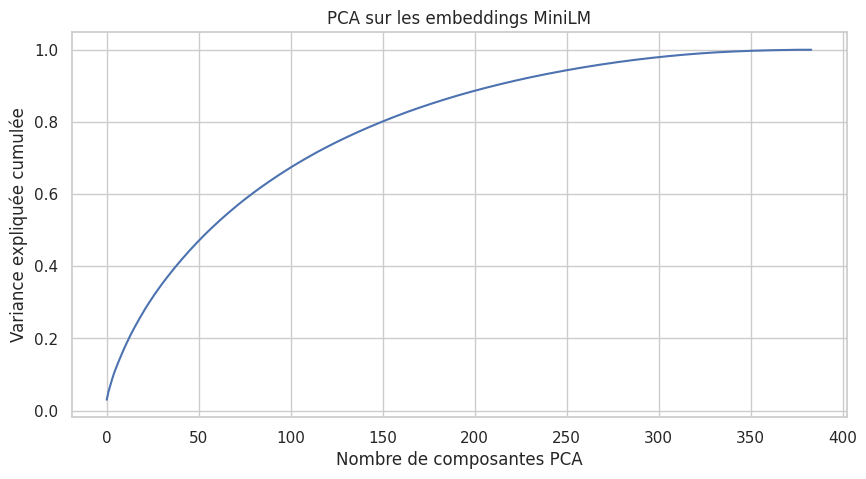

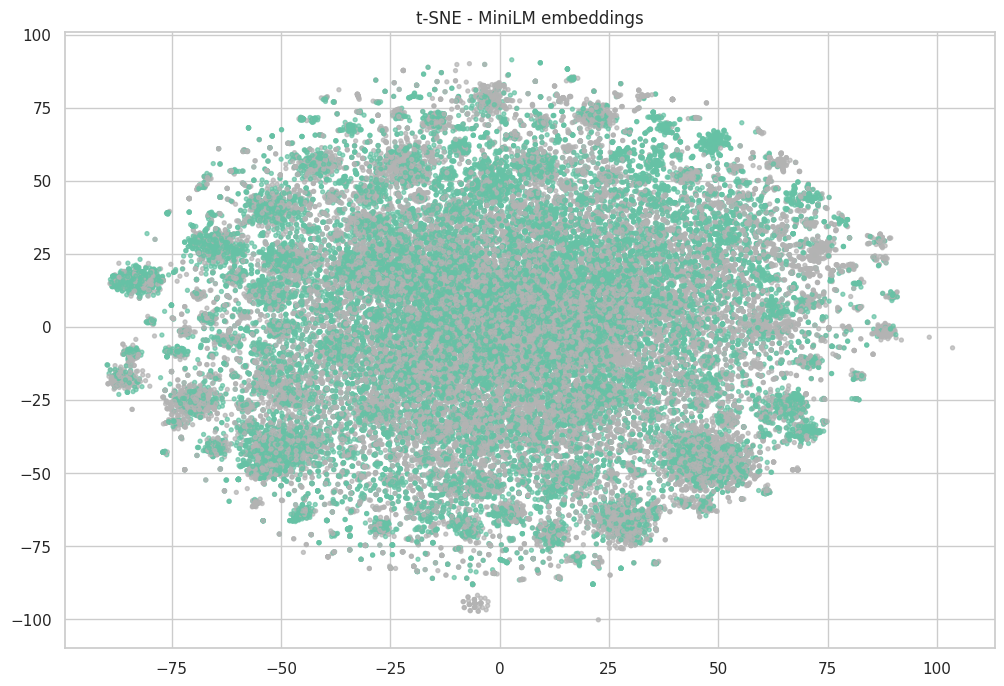

In [39]:
# PCA
pca = PCA()
pca.fit(minilm_embeddings)
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes PCA')
plt.ylabel('Variance expliquée cumulée')
plt.title('PCA sur les embeddings MiniLM')
plt.grid(True)
plt.show()

# t-SNE
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
embeddings_2d = tsne.fit_transform(minilm_embeddings)

plt.figure(figsize=(12,8))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=labels_encoded, cmap='Set2', s=8, alpha=0.7)
plt.title("t-SNE - MiniLM embeddings")
plt.show()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    minilm_embeddings, labels, test_size=0.2, random_state=SEED, stratify=labels
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
input_dim = X_train.shape[1]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Nombre de classes : {num_classes}")

Train: (48000, 384), Test: (12000, 384)
Nombre de classes : 2


In [41]:
def build_minilm_classifier(input_dim, num_classes):
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

classifier = build_minilm_classifier(input_dim, num_classes)
classifier.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,378 (552.26 KB)

 Trainable params: 140,610 (549.26 KB)

 Non-trainable params: 768 (3.00 KB)